# Convolutional Neural Network

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random        
import tensorflow as tf

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    
    return dict


In [3]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)        # reshape
    grayscale_imgs = imgs.mean(1)                        # convert to grayscale
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [4]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

In [5]:
names, data, labels = read_data('./cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


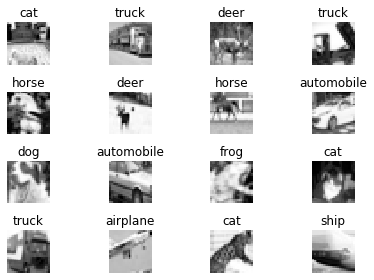

In [6]:
def show_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 4, 4
    random_idxs = random.sample(range(len(data)), rows * cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24, 24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('cifar_examples.png')
    
show_some_examples(names, data, labels)

In [7]:
W = tf.Variable(tf.random_normal([5, 5, 1, 32]))
def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.


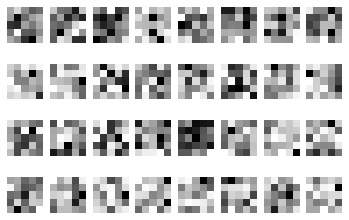

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W_val = sess.run(W)
    show_weights(W_val, 'step0_weights.png')

In [9]:
def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

(1, 24, 24, 32)
(1, 24, 24, 32)


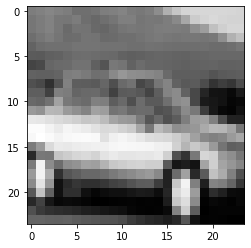

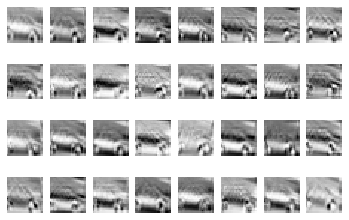

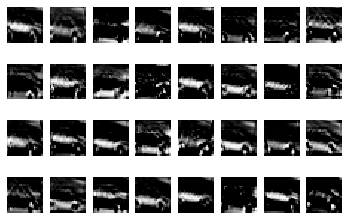

In [10]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
#plt.savefig('input_image.png')
x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])
b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_results(conv_val, 'step1_convs.png')
    print(np.shape(conv_val))
    conv_out_val = sess.run(conv_out)
    show_conv_results(conv_out_val, 'step2_conv_outs.png')
    print(np.shape(conv_out_val))

(1, 12, 12, 32)


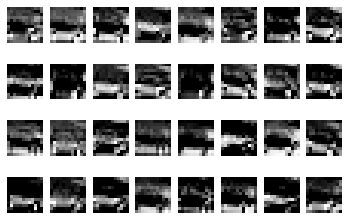

In [11]:
k = 2
maxpool = tf.nn.max_pool(conv_out,ksize=[1, k, k, 1],strides=[1, k, k, 1],padding='SAME')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    maxpool_val = sess.run(maxpool)
    show_conv_results(maxpool_val, 'step3_maxpool.png')
    print(np.shape(maxpool_val))

In [12]:
x = tf.placeholder(tf.float32, [None, 24 * 24])
y = tf.placeholder(tf.float32, [None, len(names)])
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64]))
b1 = tf.Variable(tf.random_normal([64]))
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64]))
b2 = tf.Variable(tf.random_normal([64]))
W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))
W_out = tf.Variable(tf.random_normal([1024, len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

In [13]:
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out

def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [14]:
def model():
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0,beta=0.75)
    
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1,W3.get_shape().as_list()[0]])
    
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [15]:
model_op = model()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model_op, labels=y))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0.,axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in range(0, 50):
        print('EPOCH', j)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x:batch_data, y: batch_onehot_vals})
            if i % 1000 == 0:
                print(i, accuracy_val)
        print('DONE WITH EPOCH')

batch size 250
EPOCH 0
0 0.116
1000 0.084
2000 0.092
3000 0.168
4000 0.124
5000 0.128
6000 0.156
7000 0.184
8000 0.18
9000 0.108
10000 0.2
11000 0.148
12000 0.164
13000 0.144
14000 0.14
15000 0.148
16000 0.176
17000 0.192
18000 0.16
19000 0.148
20000 0.124
21000 0.18
22000 0.22
23000 0.22
24000 0.248
25000 0.212
26000 0.236
27000 0.168
28000 0.168
29000 0.232
30000 0.188
31000 0.236
32000 0.216
33000 0.208
34000 0.22
35000 0.172
36000 0.24
37000 0.188
38000 0.192
39000 0.228
40000 0.216
41000 0.184
42000 0.192
43000 0.236
44000 0.196
45000 0.232
46000 0.208
47000 0.22
48000 0.256
49000 0.248
DONE WITH EPOCH
EPOCH 1
0 0.196
1000 0.272
2000 0.224
3000 0.26
4000 0.176
5000 0.18
6000 0.256
7000 0.224
8000 0.28
9000 0.26
10000 0.264
11000 0.268
12000 0.236
13000 0.24
14000 0.188
15000 0.212
16000 0.24
17000 0.288
18000 0.244
19000 0.236
20000 0.172
21000 0.24
22000 0.288
23000 0.212
24000 0.292
25000 0.268
26000 0.276
27000 0.224
28000 0.264
29000 0.252
30000 0.22
31000 0.232
32000 0.26
330

33000 0.288
34000 0.372
35000 0.32
36000 0.344
37000 0.308
38000 0.316
39000 0.344
40000 0.316
41000 0.36
42000 0.312
43000 0.348
44000 0.356
45000 0.312
46000 0.4
47000 0.376
48000 0.308
49000 0.388
DONE WITH EPOCH
EPOCH 14
0 0.356
1000 0.388
2000 0.312
3000 0.388
4000 0.312
5000 0.332
6000 0.3
7000 0.308
8000 0.412
9000 0.344
10000 0.376
11000 0.42
12000 0.368
13000 0.344
14000 0.32
15000 0.336
16000 0.284
17000 0.364
18000 0.344
19000 0.396
20000 0.316
21000 0.38
22000 0.392
23000 0.404
24000 0.408
25000 0.344
26000 0.376
27000 0.356
28000 0.352
29000 0.36
30000 0.324
31000 0.324
32000 0.356
33000 0.3
34000 0.384
35000 0.344
36000 0.364
37000 0.32
38000 0.356
39000 0.34
40000 0.316
41000 0.4
42000 0.328
43000 0.312
44000 0.352
45000 0.304
46000 0.4
47000 0.344
48000 0.292
49000 0.392
DONE WITH EPOCH
EPOCH 15
0 0.336
1000 0.36
2000 0.32
3000 0.376
4000 0.288
5000 0.364
6000 0.268
7000 0.352
8000 0.348
9000 0.352
10000 0.344
11000 0.436
12000 0.38
13000 0.336
14000 0.304
15000 0.34
16

15000 0.344
16000 0.332
17000 0.408
18000 0.368
19000 0.36
20000 0.384
21000 0.408
22000 0.372
23000 0.42
24000 0.452
25000 0.408
26000 0.388
27000 0.332
28000 0.428
29000 0.356
30000 0.356
31000 0.336
32000 0.368
33000 0.388
34000 0.444
35000 0.38
36000 0.368
37000 0.356
38000 0.3
39000 0.38
40000 0.36
41000 0.44
42000 0.38
43000 0.392
44000 0.404
45000 0.376
46000 0.324
47000 0.372
48000 0.308
49000 0.44
DONE WITH EPOCH
EPOCH 28
0 0.436
1000 0.472
2000 0.324
3000 0.396
4000 0.348
5000 0.388
6000 0.372
7000 0.384
8000 0.408
9000 0.376
10000 0.376
11000 0.424
12000 0.448
13000 0.344
14000 0.36
15000 0.384
16000 0.376
17000 0.388
18000 0.408
19000 0.38
20000 0.356
21000 0.408
22000 0.428
23000 0.428
24000 0.448
25000 0.448
26000 0.436
27000 0.38
28000 0.396
29000 0.4
30000 0.38
31000 0.392
32000 0.4
33000 0.372
34000 0.404
35000 0.364
36000 0.396
37000 0.34
38000 0.364
39000 0.384
40000 0.348
41000 0.432
42000 0.392
43000 0.38
44000 0.38
45000 0.428
46000 0.424
47000 0.452
48000 0.292
4

DONE WITH EPOCH
EPOCH 41
0 0.4
1000 0.46
2000 0.412
3000 0.432
4000 0.232
5000 0.368
6000 0.332
7000 0.388
8000 0.312
9000 0.356
10000 0.444
11000 0.44
12000 0.416
13000 0.436
14000 0.384
15000 0.372
16000 0.376
17000 0.44
18000 0.38
19000 0.4
20000 0.408
21000 0.476
22000 0.356
23000 0.46
24000 0.476
25000 0.452
26000 0.476
27000 0.408
28000 0.468
29000 0.404
30000 0.4
31000 0.364
32000 0.368
33000 0.388
34000 0.444
35000 0.4
36000 0.468
37000 0.432
38000 0.432
39000 0.42
40000 0.4
41000 0.464
42000 0.392
43000 0.424
44000 0.416
45000 0.468
46000 0.476
47000 0.464
48000 0.352
49000 0.528
DONE WITH EPOCH
EPOCH 42
0 0.42
1000 0.516
2000 0.436
3000 0.42
4000 0.368
5000 0.42
6000 0.372
7000 0.404
8000 0.396
9000 0.428
10000 0.436
11000 0.412
12000 0.372
13000 0.432
14000 0.412
15000 0.392
16000 0.412
17000 0.46
18000 0.38
19000 0.46
20000 0.436
21000 0.476
22000 0.368
23000 0.48
24000 0.452
25000 0.432
26000 0.456
27000 0.384
28000 0.48
29000 0.444
30000 0.388
31000 0.388
32000 0.384
3300